In [1]:
%%capture
# DO NOT EDIT THIS NOTEBOOK
# It generates a report to verify your submission
import logging, sys, os
logging.disable(sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import solution
import time
start_verify = time.time()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3)

In [2]:
%matplotlib inline
import os
import pickle
import pandas as pd
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import inspect
from IPython.core import page
page.page = print

grades = []

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')
        
def printSource(obj):
    print(''.join(str(x) for x in inspect.getsourcelines(obj)[0]))
        
# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

def print_answer(ans):
    output = ""
    for line in ans.splitlines()[1:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)
        
def run_evaluation(name, model_builder, data, base_dir, target_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        grades.append("0")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Model not trained? Skipping.", verbose)
    else: # Load from file
        model = solution.load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    grades.append("{:.2f}".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()
    
    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(target_dir,name+'.png'), show_shapes=True, show_layer_names=False)
        
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Web Information Retrieval and Data Mining - Assignment 3

In [3]:
grades.append(solution.target_dir.split(os.sep)[-1])
grades.append(solution.your_name)
print("Student: {0} ({1})".format(solution.your_name,solution.student_id))

Student: Keles, Isilsu (1035673)


#### Answer 1.1, Baseline (4p)
- Dense network, at least 3 layers, shaped like a pyramid
    - Last layer: 10 nodes, sigmoid. 
    - Loss: categorical cross-entropy. Metric: accuracy
- No preprocessing, regularization. Get at least 70% accuracy.
- Explain design decisions. Discuss performance.
    - Does it overfit (large/growing gap between loss and val_loss)?

I added five layers in my sequential model. The first is a reshaper, to vectorize the features from 32*32*3 into 3072 values. This layer is followed by four dense layers shaped like a pyramid with 80 nodes for the first, then the number of nodes is halved for every subsequent layer, i.e. 40, 20 ,10 respectively. I use sigmoid first to compress the data between 0 and 1. Next, I use ReLU twice because it is usually used when considering non- linear data; and the pixels in the image are not linearly related to each other. Using ReLU introduces nonlinearity which matches the nature of the data and also matches the problem of image classification being a nonlinear problem. The final layer is softmax with 10 nodes. That makes softmax give probabilities for the input belonging to each of the 10 classes. Then the class chosen by the model is the one with the highest probability in the softmax layer. At 20 epochs, this gave accuracy of 72%. At 50 epochs, 75% accuracy.  (length: 975)



Max val score: 76.14%


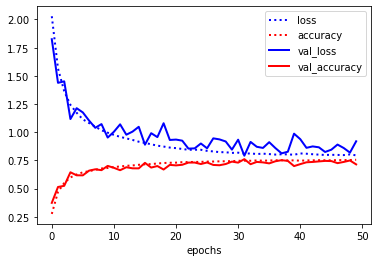

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 80)                245840    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 250,110
Trainable params: 250,110
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(80, activation='sigmoid'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



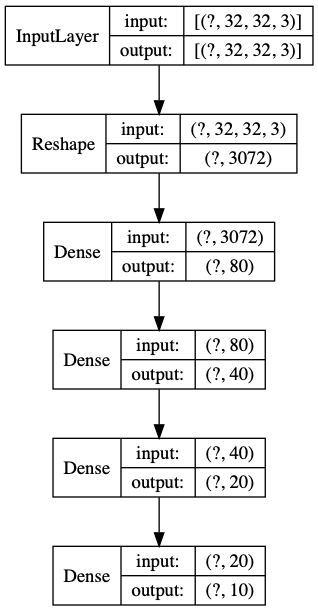

In [4]:
print_answer(solution.answer_q_1_1)
run_evaluation("model_1_1", solution.build_model_1_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_1
if os.path.exists(os.path.join(solution.target_dir,'model_1_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_1_1.png'), width=200))

#### Answer 1.2, Preprocess (2p)
- Convert images to greyscale, other preprocessing optional.
    - Input shape should be (32,32,1)
- Explain design decisions. Is it better? Why (not)? 
    - Color information is likely not so useful for classification. Greyscale makes the network smaller, less parameters to learn, less likely to overfit.

I used the provided rgb2gray method and no further preprocessing. The model returned considerably better results (up from 72% accuracy to 78%). The reason is that RGB data does not help identify the number in an image. Converting RGB to greyscale reduces the complexity and size of the data which not only makes the training and classification faster but also removes unnecessary infromation that may otherwise sway the model into classifying features that are not related to the problem. Considering unrelated properties causes unwanted bias in the model. At 20 epochs, this gave a 77% accuracy model. At 50 epochs, 81%.  (length: 623)



Max val score: 80.56%


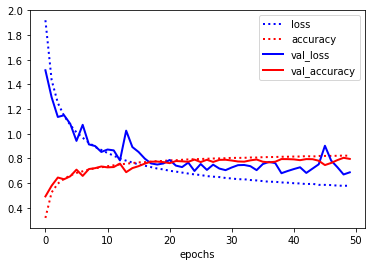

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                82000     
_________________________________________________________________
dense_5 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
Total params: 86,270
Trainable params: 86,270
Non-trainable params: 0
_________________________________________________________________
None


def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(80, activation='sigmoid'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [5]:
print_answer(solution.answer_q_1_2)
run_evaluation("model_1_2", solution.build_model_1_2, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_1_2

#### Answer 1.3, Tune (4p)
- Regularize the model. What works best? 
    - Should consider batch normalization, dropout, l1/l2 regularization (or Nesterov)
- Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
    - At least consider tuning learning rate, ideally also momentum, decay, other optimizers 
- Explain your findings and final design decisions. Discuss the results.
    - Should be better, at least it shouldn't overfit

I ran about 60 experiments at 50 epochs. Findings: Layers: Neither adding layers intermediate (60, 30 nodes) or above (160, 320 nodes), nor changing activations (ELU, tanh) nor Dropouts did imporve. Best Batch size out of 8 values ranging from 16 to 128 was found 48. Best Optimzer out of 7 different ones was Nadam. Best Learning rate on Nadam=0.00125. Kernel regularizer applied to the 20-node ReLU layer and softmax layer was good. On more layers is bad. Other regularizers were bad.  (length: 488)



Max val score: 80.92%


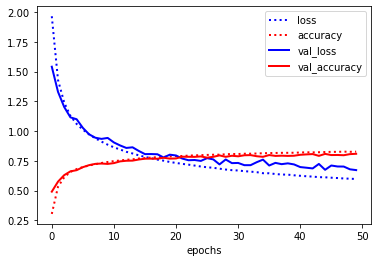

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(80, activation='sigmoid'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))
    model.compile(optimizer=Nadam(learning_rate=0.00125),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
print_answer(solution.answer_q_1_3)
run_evaluation("model_1_3", solution.build_model_1_3, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
%psource solution.build_model_1_3

#### Answer 2.1, ConvNet (7p)
- Build a sequential ConvNet, get at least 90% accuracy.
    - Conv2D layers, input shape (32,32,1)
    - Consider using blocks of Conv2D layers with maxpooling in between
    - Use zero-padding in Conv2D layers because the images are small
    - At least one dense hidden layer and dense output layer (sigmoid)
    - Consider adding batch normalization, dropout
    - Consider small dropout rates in beginning, larger dropout rates later in network
    - Consider other optimizers and tuning learning rate, momentum,...
- Explain what you did and why (800 chars). Is it working well?
    - Should be quite elaborate and sensible

Starting with only two conv layers achieved the requirement but was very overfitted. So I added regularizers and dropouts, which were very effective in removing overfitting. although dropouts increase val_accuracy, they reduce train accuracy significantly so I added more conv layers and increased droptouts gradually until I reached a balance where increasing dropout benefits no more. Higher number of nodes did not help. Other choices (optimizer, learning rate, batch size) carried on from 1.3. Changing them did not improve the model. 20 epochs are enough to achieve satisfactory val_accuracy, but more epochs reveal the overfitting more clearly. I added batch normalization (after each conv layer) since it's useful with regularization and speeds up the training anyway.   (length: 778)



Max val score: 95.72%


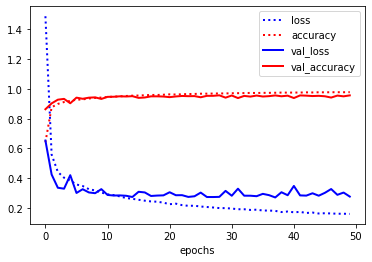

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)       

def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))

  mod

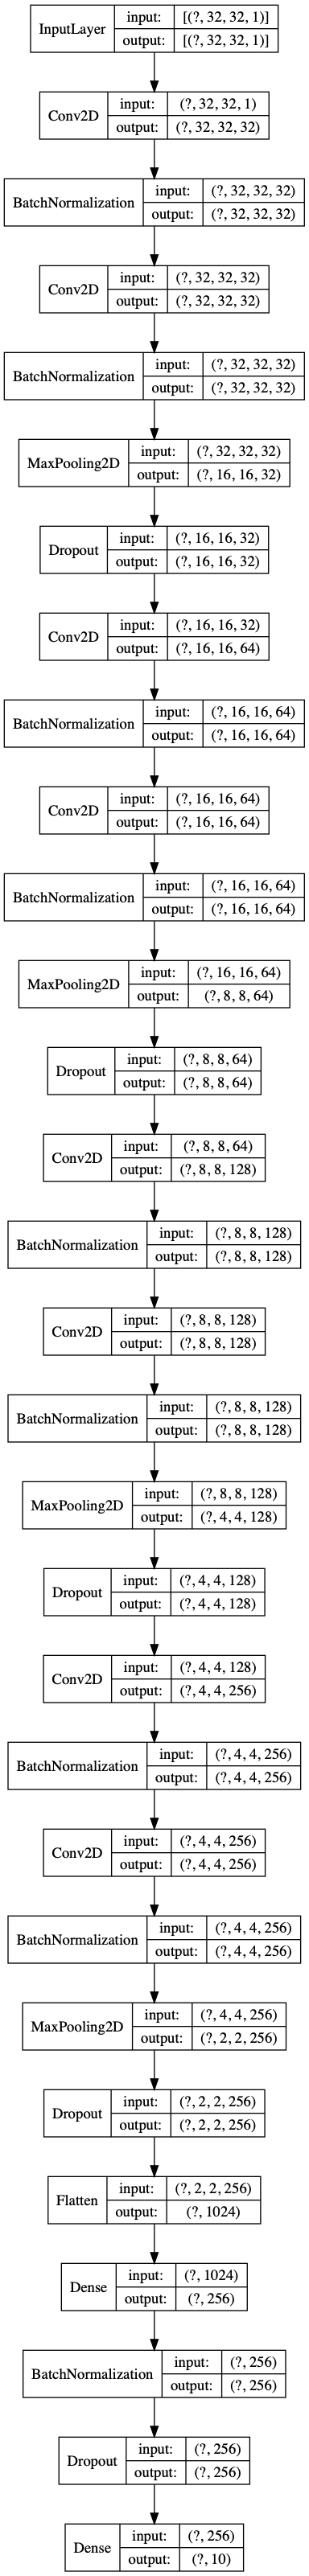

In [7]:
print_answer(solution.answer_q_2_1)
run_evaluation("model_2_1", solution.build_model_2_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_2_1
if os.path.exists(os.path.join(solution.target_dir,'model_2_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_2_1.png'), width=200))

#### Answer 2.2, Data Augmentation (3p)
- Augment the preprocessed training data.
    - Use small variations (small shifts up-down, left-right) of flips becasue the images are small
    - Large shifts and rotations distort the image too much
- Explain what you did and why. Discuss the performance of the model.

this did not help in any scenario I tried. zca whitening was bad with different epsilons. shear range and zoom range the more the worse. rotation range, samplewise center, both std_normalizations were all bad. samplewise_std_normalization caused much overfiting horizontal flip is useless. fill mode wrap and featurewise center were ok. a consistent preprocessing rule is better than random augments. e.g. crop 10 pixels from right and left. Most digits lie entirely in the horizontal center.   (length: 495)



Max val score: 90.83%


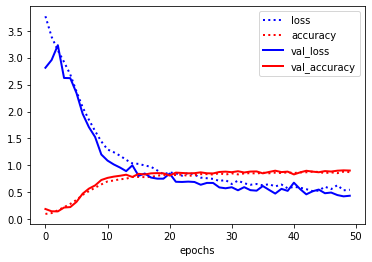


train_datagen = ImageDataGenerator(
    featurewise_center=True, 
    samplewise_center=False,
    featurewise_std_normalization=False, 
    samplewise_std_normalization=False,
    # zca_whitening=True, 
    # zca_epsilon=1e-04, 
    # rotation_range=30,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    brightness_range=None,
    # shear_range=0.1,
    # zoom_range=0.1,
    channel_shift_range=0.1, 
    # fill_mode='nearest', 
    fill_mode='wrap', 
    cval=0.1, 
    horizontal_flip=False,
    vertical_flip=False, 
    rescale=None, 
    preprocessing_function=None,
    data_format=None, 
    validation_split=0.0, 
    dtype=None
    )


In [8]:
print_answer(solution.answer_q_2_2)
run_evaluation("model_2_2", solution.build_model_2_1, solution.augmented_split, solution.base_dir, 
               solution.target_dir, train=False, print_model=False)
print(solution.dg_code)

#### Answer 3.1, Misclassifications (2p)
- Report the test score (on the held-out test data)
    - Should be similar to score of previous model
- Plot confusion matrix, discuss which classes are often confused.
    - class 1 and 2 are most often confused
- Visualize the misclassifications in more depth by focusing on a single class
- Analyse which kinds of mistakes are made for that class.
    - Should contain some insight (e.g. misclassifications when the numbers are curly or noisy)

5 misclassified as 6 is the most common. the opposite is rare.so there is a bias towards 6. 2nd most is 7 misclassified as 1. The opposite is much less. perhaps must preprocess so that the horizontal top of 7 stands out. 3 of the 5 pictures shown are low quality, out of focus, or smudged. Some cases a neighbouring digit takes over like 0'1'0 misclassified as 0 instead of 1. hence the crop suggestion in 2.2. In class 3, 4 out of 5 are like that.  (length: 450)

Test score: 0.91%


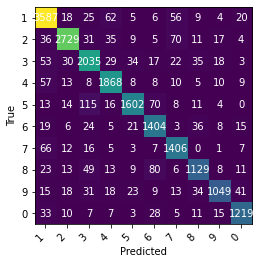

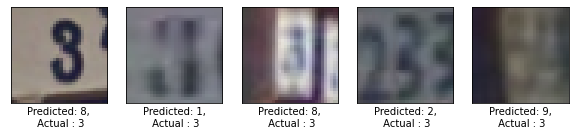

In [9]:
print_answer(solution.answer_q_3_1)
if hasattr(solution, 'test_accuracy_3_1'):
    try:
        print("Test score: {:.2f}%".format(solution.test_accuracy_3_1))
    except TypeError:
        print("Test score:",solution.test_accuracy_3_1)
else:
    print("Test score NOT FOUND: test_accuracy_3_1 missing")
try:
    solution.plot_confusion_matrix()
except:
    print("ERROR, could not build confusion matrix. Please check original report")
try:
    solution.plot_misclassifications()
except:
    print("ERROR, could not build misclassification plot. Please check original report")

#### Answer 3.2, Activations (4p)
- Retrieve and visualize the activations for one example
- For every filter for different convolutional layers (at different depths in the network).
- Give an explanation. Is your model indeed learning something useful?
    - Should detect edges etc in first layers, higher-order object (e.g. interesting regions) in deeper layers.

The visualization shows that the model is indeed learning something useful. detecting edges and contours from different directions. we see it detecting featurs that discern 8 figure from 6 and 0 and 3 which are its common misclassifications. The deeper the layer the less comprehensible but we see fourth layer detecting the circles inside the 8 and the borders of the shape.  (length: 377)



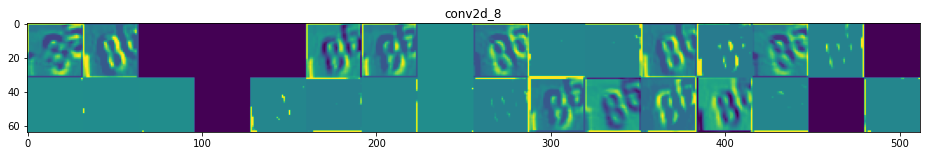

In [10]:
print_answer(solution.answer_q_3_2)
try:
    solution.plot_activations()
except:
    print("ERROR, could not build activation plot. Please check original report")

#### Answer 3.3, Class activation map (4p)
- Show a class activation map for your last convolutional layer
- Superimpose the activation map over the image, or plot side by side
    - Should make sense, detect interesting regions to classify the number

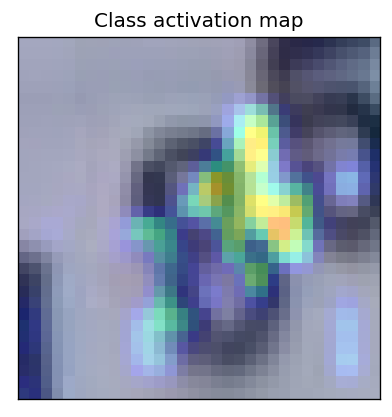

def plot_activation_map():
  # plot_activations(8,9)
  tf.compat.v1.disable_eager_execution()
  K.clear_session()
  model = load_model_from_file(base_dir, "model_2_2")
  img = X_test_gray[0]
  img_tensor = np.expand_dims(img, axis=0)
  img_pred = model.predict(img_tensor)

  img_output = model.output[:, np.argmax(img_pred[0])]
  # last_conv_layer = model.get_layer('conv2d_32')
  last_conv_layer = model.get_layer(index=8)

  # This is the gradient of the class with regard to
  # the output feature map of last conv layer
  grads = K.gradients(img_output, last_conv_layer.output)[0]

  # This is a vector of shape (512,), where each entry
  # is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # This function allows us to access the values of the quantities we just defined:
  # `pooled_grads` and the output feature map of the last conv layer,
  # given a sample image
  iterate = K.function([model.input], [pooled_grads, 

In [11]:
try:
    solution.plot_3_3()
except:
    print("ERROR, could not build class activation plot. Please check original report")
if hasattr(solution, 'plot_activation_map'):
    %psource solution.plot_activation_map
else:
    %psource solution.plot_3_3

#### Answer 4.1, Fast feature extraction (5p)
- Import the VGG16 model, pretrained on ImageNet
- Freeze convolutional base, adds a dense layer
- Consider unfreezing the last few convolutional layers and evaluate whether that works better
    - Check if they do. It is very likely to help.
- Discuss the observed performance
    - Should get around 80% accuracy

Freezing all conv layers gives 90% acc and 90% val_acc at 10 epochs. Unfreezing the last 3 conv layers achieves 98% acc and 97% val_acc, a big improvement. no overfitting. clean curve. pretrained vgg16 is very effective in visual classification together with transfer learning given last three conv layers are trained.  (length: 320)



Max val score: 96.85%


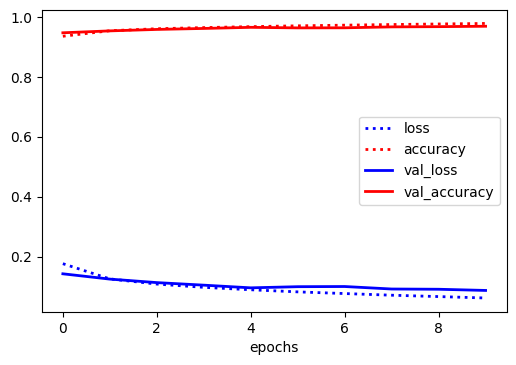

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________
None


def build_model_4_1():
  model = models.Sequential()
  conv_base = VGG16(include_top=False, 
                    input_shape=(32, 32, 3), 
                    classes=10, 
                    pooling='avg',)
  
  # for layer in conv_base.layers:
  #   layer.trainable = False
  conv_base.trainable = True

  for layer in conv_base.layers:
    if layer.name.startswith('block5_conv'):
        layer.trainable = True
    else:
        layer.trainable = False

  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  
  # for layer in model.layers[0].layers[:14]:
  #   layer.trainable = False
  
  model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model



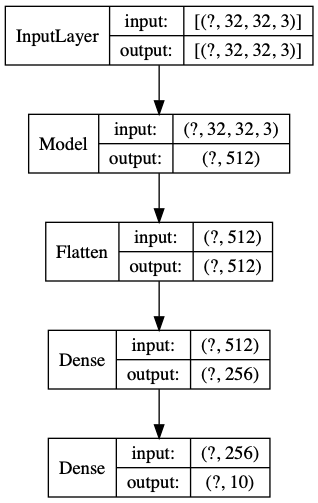

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

print_answer(solution.answer_q_4_1)
run_evaluation("model_4_1", solution.build_model_4_1, solution.evaluation_split, solution.base_dir, 
               solution.target_dir, train=False)
%psource solution.build_model_4_1
if os.path.exists(os.path.join(solution.target_dir,'model_4_1.png')):
    display(Image(os.path.join(solution.target_dir,'model_4_1.png'), width=200))
#solution.build_model_4_1().layers[0].summary()

#### Answer 4.2, Embeddings (5p)
- Generate embeddings with the trained convolutional part of model_4_1 (without the dense layer)
- Embed the training and test data and store them to disk
- Build and evaluate a pipeline on the embedded data
    - Check if pipeline makes sense (e.g. use models that can handle many dimensions)
- Describe what you did and what you observed (max 800 chars).
    - Consider different models, preprocessing, tuning, etc.
    - Check performance (see original Submission.html) when in doubt. We did not run all the evaluations because it takes too long, and the output is ill-defined.

In [13]:
print_answer(solution.answer_q_4_2)
print(solution.generate_pipeline())
#print("Evaluation:",solution.evaluation_4_2(solution.X_train, solution.y_train, solution.X_test, solution.y_test))
%psource solution.store_embeddings
%psource solution.evaluation_4_2

I made a pipeline similar to assignment 2. Tried SVM, logistic regresssion and RF with multiple scalers. SVM with StandardScaler performed the best at 83.5% yet all combinations of imported classifiers and scalers were tested and performed very closely. Trying different SVM parameters did not improve either. It appears that non-deep-learning classifiers are worse extensions to CNNs than dense layers.  (length: 405)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('classifier', SVC(random_state=1))])
def store_embeddings():
  """ Stores all necessary embeddings to file
  """
  model = load_model_from_file(base_dir, "model_4_1").layers[0]
  embedding_train = model.predict(X_train)
  embedding_test = model.predict(X_test)
  store_embedding(embedding_train, 'Train')
  store_embedding(embedding_test, 'Test')

def evaluation_4_2(X_train, y_train, X_test, y_test):
  """ Runs 'evaluate_pipeline' with embedded versions of the input data 
  and returns the accuracy.
  """
  

In [14]:
end_verify = time.time()
print("Running time: {:.2f} seconds".format(end_verify - start_verify))
print("Last modified: {}".format(solution.last_edit))
print("scikit-learn version: {0}".format(solution.sklearn_version))

with open(solution.grade_file, "a") as myfile:
    myfile.write(','.join(grades)+"\n")

Running time: 21.71 seconds
Last modified: May 26, 2020
scikit-learn version: 0.23.1
